<font color='blue'> **SFRmaker** </font> .. then sfrmaker.mf5to6

In [1]:
import numpy as np  ; import matplotlib.pyplot as plt   ; import flopy  ; import sfrmaker ; from pathlib import Path ; import geopandas as gpd ; import os ; import earthpy.spatial as es
import rasterio as rio ; import earthpy.plot as ep            ; TA = Path("./TA") ;TA.mkdir(exist_ok=True) ; TB = Path("./TB") ;TB.mkdir(exist_ok=True) 
R1=Path('E:/15_REPOS/02_Beta-Me/data/sfrmaker/tylerforks')    ; R2=(R1/'dem_26715.tif') ;B0=flopy.utils.Raster.load(R1/"dem_26715.tif")  ; VEC1 = gpd.read_file(os.path.join(R1/'grid.shp'))
VEC2 = gpd.read_file(os.path.join(R1/'active_area.shp'))      ; R3=(R1/'NHDPlus/NHDPlusAttributes')                                      ; R4=(R1/'NHDPlus/NHDSnapshot/Hydrography')
VEB1=os.path.join('E:/15_REPOS/02_Beta-Me/data/sfrmaker/meras/flowlines.shp')           ; VEC3 = gpd.read_file(VEB1)                     ; VEB2=os.path.join(R1/'active_area.shp')
UA=os.path.join(R1/'NHDPlus') ; UB=('E:/15_REPOS/02_Beta-Me/data/sfrmaker/tylerforks')

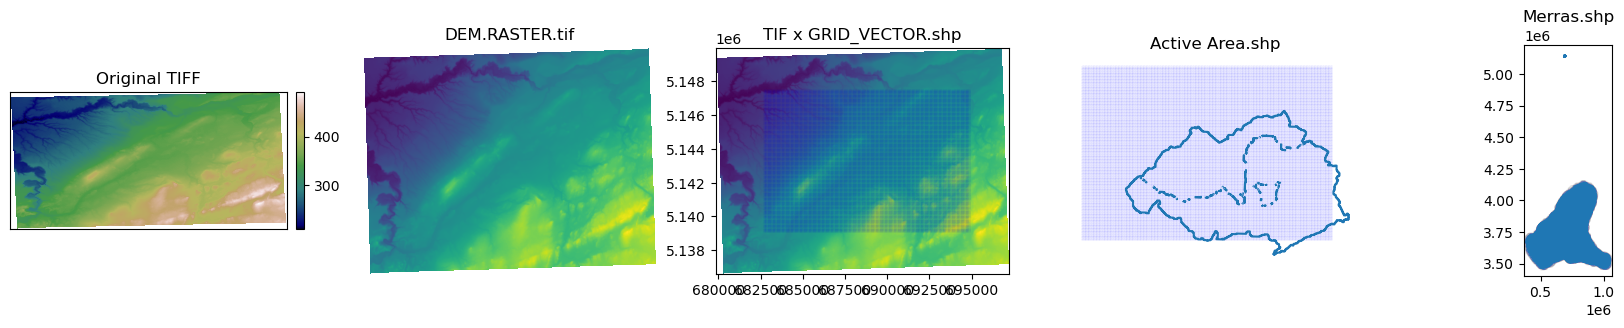

In [2]:
OVER1=VEC1.to_crs(es.crs_check(R2))                ; OVER2=VEC2.to_crs(es.crs_check(R2))                    ; OVER3=VEC3.to_crs(es.crs_check(R2))
with rio.open(R2) as src:                            ELEV = src.read(1).astype("float")                     ; ELEV[ELEV < 0] = np.nan    
               
fig = plt.figure(figsize=(22,3))                                                         
ax = fig.add_subplot(151)  ; ep.plot_bands(ELEV           , title="Original TIFF" , cmap="gist_earth", ax=ax)  
ax = fig.add_subplot(152)  ; B0.plot(ax=ax)               ; plt.title("DEM.RASTER.tif") ; plt.axis('off')
ax = fig.add_subplot(153)  ; B0.plot(ax=ax)               ; OVER1.boundary.plot(ax=ax, color='b',alpha=0.03 ) ; plt.title("TIF x GRID_VECTOR.shp")
ax = fig.add_subplot(154)  ; plt.title("Active Area.shp") ; OVER1.boundary.plot(ax=ax, color='b',alpha=0.03 ) ; OVER2.boundary.plot(ax=ax) ; plt.axis('off')
ax = fig.add_subplot(155)  ; plt.title("Merras.shp")      ; OVER3.boundary.plot(ax=ax, alpha=0.003)  ;  OVER2.boundary.plot(ax=ax)                          ; plt.show(block=False)    

In [3]:
%%capture   
LNS1 = sfrmaker.Lines.from_nhdplus_v2(NHDPlus_paths=UA           , bbox_filter=os.path.join(R1/'grid.shp'))
LNS2 = sfrmaker.Lines.from_nhdplus_v2(NHDFlowlines=os.path.join(R4/'NHDFlowline.shp')  , PlusFlowlineVAA=os.path.join(R3/'PlusFlowlineVAA.dbf'),
                                      PlusFlow    =os.path.join(R3/'PlusFlow.dbf')     , elevslope= os.path.join(R3/'elevslope.dbf')        ,bbox_filter=(-90.625, 46.3788, -90.4634, 46.4586))
LNS3 = sfrmaker.Lines.from_shapefile(shapefile=VEB1,id_column='COMID',  routing_column='tocomid',width1_column='width1',width2_column='width2' ,
                                     up_elevation_column='elevupsmo',dn_elevation_column='elevdnsmo',name_column='GNIS_NAME',attr_length_units='feet',  attr_height_units='feet') #QGIS

In [4]:
%%capture
delr = np.array([250*0.3048] * 160)  ; delc = np.array([250*0.3048] * 111)  
A_GRID = flopy.discretization.StructuredGrid    (delr=delr, delc=delc,xoff=682688, yoff=5139052,  angrot=0,  crs=26715)                    
B_GRID = sfrmaker.StructuredGrid.from_shapefile (shapefile=os.path.join(R1/'grid.shp'),icol='i',  jcol='j',  active_area=VEB2)          #plt.imshow(B_GRID.isfr, interpolation='nearest')

In [5]:
m = flopy.modflow.Modflow.load('tf.nam', model_ws=R1/'tylerforks')       ; m     #; SFRD = lines.to_sfr( grid = A_GRID   ,model=m,model_length_units='feet')

MODFLOW 5 layer(s) 111 row(s) 160 column(s) 1 stress period(s)

In [6]:
%%capture
SFRD = LNS2.to_sfr( grid = A_GRID  ,model = m ,model_length_units='feet')       # LNS3 # No lines in active area.
SFRD.reach_data.loc[SFRD.reach_data['rno'] == 1, 'strhc1'] = 5        ; SFRD.reach_data.to_csv(TA/'01reach_data.csv')      # SFRD.segment_data.to_csv(TA/'02segment_data.csv')
SFRD.set_streambed_top_elevations_from_dem(R1/'dem_26715.tif', elevation_units='meters')
SFRD.assign_layers() ; # SFRD.reach_data.head()

In [12]:
%%capture
SFRD.run_diagnostics(verbose=False)     ; SFRD.write_package()      ; SFRD.write_package(version='mf6')     ; SFRD.write_tables()
SFRD2 = sfrmaker.SFRData.from_tables('tables/tf_sfr_reach_data.csv', 'tables/tf_sfr_segment_data.csv',grid=A_GRID)
SFRD.write_shapefiles()

<font color='blue'> **Diagnostics** </font> <br>
`SFRData` includes a `run_diagnostics()` method that executes the Flopy checker on the SFR package input. While the Flopy checks are only implemented for MODFLOW-2005 style SFR packages, `run_diagnostics()` works on MODFLOW-6 packages as well, by working of an attached MODFLOW-2005 representation of the MODFLOW-6 SFR input. The following checks are executed:
* **NaNs** (not a number values, which will cause MODFLOW to crash)
* **consecutive segment and reach numbering**
* **segment numbering that only increases** in the downstream direction
* **circular routing sequences** (reaches or segments routing back to themselves)
* **routing connection proximity:** The length of routing connections, as determined by the distance between their cell centers, is compared to 1.25 times the diagonal distance across the cell containing the upstream reach. This benchmark length is equivalent to a diagonal connection between two square cells, where one cell had a spacing of 1.5 times the other cell (the maximum recommended increase in spacing between two adjacent cells; see Anderson and others, 2015). While this routing proximity check can be helpful for identifying egregious routing issues, in practice, it may not be uncommon for valid routing connections to violate this rule. For example, if the ``one_reach_per_cell`` option is used in constructing the SFR package with a large grid size, there may be numerous routing connections that extend across several cells. When non-adjacent routing connections are identified, the user can check the shapefile of routing connections to verify the results.
* **overlapping conductances:** This check identifies instances of collocated reaches, where more than one reach has a connection to the groundwater flow solution in that cell. Collocated reaches may or may not present an issue for a particular model solution, but can potentially promote instability or spurious circulation of flow between the collocated reaches.
* **spurious streambed top elevations:** Values < -10 or > 15,000 are flagged
* **downstream rises in streambed elevation**
* **inconsistencies between streambed elevation and the model grid:** This check looks for streambed bottoms below their respective cell bottoms, which will cause MODFLOW to halt execution, and streambed tops that are above the model top. The latter issue will not prevent MODFLOW from running, but may indicate problems with the input if the differences are large. For coarse grids in areas of high stream density (where there are often multiple streams in a cell), it may be impossible to ensure that all streambed top elevations are at or below the model top. Oftentimes, these reaches are dry anyways (for example, and ephemeral gully that runs off a bluff into a perennial stream, where the cell elevation is based on the elevation of the perennial stream). In any case, it is good practice to check the largest violations by comparing the SFRmaker shapefile output to a DEM and other data in a GIS environment.
* **suprious slopes:** slopes of less than 0.0001 (which can lead to excessive stages with the SFR package's Manning approximation) and greater than 1.0 are flagged.

<font color='blue'> **Writing shapefiles** </font> <br>
Shapefiles can also be written to visualize the SFR package. These include:
* hydrography linestrings associated with each reach
* model cell polygons associated with each reach
* outlet locations where water is leaving the model
* routing connections (as lines drawn between cell centers)
* the locations of specified inflows or any other period data
* observation locations (if observations were supplied as input)